### Erin Shi

In [1]:
!pip install -U -q tensorflow tensorflow_datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.0 MB/s eta 0:00:00


In [67]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers,models,callbacks,regularizers

from IPython import display

import librosa

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

### Import and squeeze data

In [68]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [69]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['stop' 'yes' 'down' 'left' 'no' 'right' 'up' 'go']


In [70]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both'
)

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [71]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [72]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [73]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [74]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


### Convert waveforms to spectrograms

In [75]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [76]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [77]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

## Task 1: Optimized CNN model

In [78]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [79]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

In [88]:
# Get the input shape from example spectrograms
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)

# Number of labels
num_labels = len(label_names)

# Instantiate the normalization layer
norm_layer = layers.Normalization()

# Fit the state of the layer to the spectrograms
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

# Create a sequential model
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Adjust learning rate
    # Remove the "from_logits=True" since the last dense layer uses `softmax`
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'],
)

# Added more epochs
EPOCHS = 25

# Model training
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2, restore_best_weights=True),
)


Input shape: (124, 129, 1)
Epoch 1/25
100/100 [==============================] - 18s 158ms/step - loss: 1.9382 - accuracy: 0.2580 - val_loss: 1.6015 - val_accuracy: 0.4766
Epoch 2/25
100/100 [==============================] - 15s 153ms/step - loss: 1.4626 - accuracy: 0.4823 - val_loss: 1.0958 - val_accuracy: 0.6823
Epoch 3/25
100/100 [==============================] - 15s 153ms/step - loss: 1.1227 - accuracy: 0.5944 - val_loss: 0.8553 - val_accuracy: 0.7201
Epoch 4/25
100/100 [==============================] - 17s 169ms/step - loss: 0.9115 - accuracy: 0.6759 - val_loss: 0.7196 - val_accuracy: 0.7995
Epoch 5/25
100/100 [==============================] - 15s 154ms/step - loss: 0.7580 - accuracy: 0.7269 - val_loss: 0.6056 - val_accuracy: 0.8138
Epoch 6/25
100/100 [==============================] - 15s 154ms/step - loss: 0.6619 - accuracy: 0.7669 - val_loss: 0.5281 - val_accuracy: 0.8451
Epoch 7/25
100/100 [==============================] - 19s 194ms/step - loss: 0.5885 - accuracy: 0.7956 

In [89]:
# Model evaluation
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 [==============================] - 1s 77ms/step - loss: 0.3281 - accuracy: 0.8822


{'loss': 0.3280864953994751, 'accuracy': 0.8822115659713745}

Text(0, 0.5, 'Accuracy [%]')

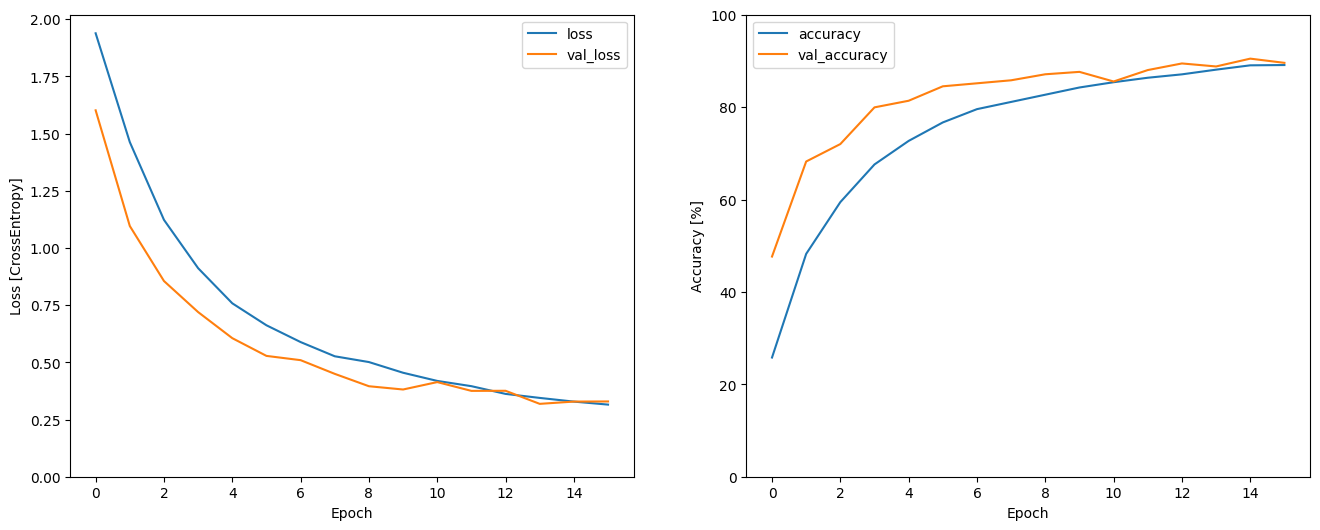

In [90]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

#### Original Model Performance:

The original model achieved a commendable accuracy of 82.93% with a loss of 0.5092.

#### Optimized Model Performance:

The optimized model has shown some improvements, reaching an accuracy of 88.82% and a loss of 0.3444.

#### Observations:
Loss Graph (Left): Both the training and validation loss decrease over time and seem to converge. There is no clear sign of the validation loss increasing or diverging from the training loss, which would indicate overfitting.

Accuracy Graph (Right): The training accuracy increases and starts to plateau, and the validation accuracy follows a similar trajectory. Both accuracies level off, and there's a small gap between them. This gap does not appear to be widening significantly as the epochs increase.

Conclusion:
There are no immediate signs of overfitting. The optimized model seems to be learning and generalizing well up to this point in the training process. The close tracking of the validation metrics to the training metrics suggests that the model is performing consistently across both datasets.

Accuracy Enhancement:
The optimized model has shown a notable improvement in accuracy.

Loss Improvement:
There's a significant reduction in the loss when moving from the original model to the optimized one. A decrease in loss from 0.5092 to 0.3444 suggests that the optimized model is providing predictions that are closer to the actual target values.

Training Strategy:
The enhancements in accuracy and loss could be attributed to a potentially more refined training strategy in the optimized model, which included an appropriate number of epochs and a better learning rate.

Generalization:
Based on the training curves, the optimized model seems to generalize better than the original model. The validation loss and accuracy closely follow the training loss and accuracy, indicating that the model is learning general patterns rather than memorizing the training data.

#### Conclusions:
The optimization efforts have yielded a model with higher accuracy and lower loss compared to the original setup. The results suggest that the adjustments made to the model's training process have enhanced its ability to classify the given spectrogram data accurately.

### Task 2: Autoencoder

In [91]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def create_modified_model(input_shape, num_labels):
    # Encoder input and structure
    encoder = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Resizing(32, 32),
        layers.BatchNormalization(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(256, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
    ])

    # Decoder input and structure
    decoder = models.Sequential([
        layers.Conv2DTranspose(256, 3, padding='same', activation='relu', strides=(2, 2)),
        layers.Conv2DTranspose(128, 3, padding='same', activation='relu', strides=(2, 2)),
        layers.Conv2DTranspose(64, 3, padding='same', activation='relu', strides=(2, 2)),
        layers.Conv2DTranspose(1, 3, padding='same', activation='sigmoid', strides=(2, 2)),
    ])

    # Fully connected layer
    fc_layer = models.Sequential([
        layers.Flatten(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(num_labels, activation='softmax')
    ])

    # Build autoencoder
    input_layer = layers.Input(shape=input_shape)
    encoded = encoder(input_layer)
    decoded = decoder(encoded)
    autoencoder = models.Model(inputs=input_layer, outputs=decoded)

    # Build classification model
    classifier_input = layers.Input(shape=input_shape)
    encoded_for_classification = encoder(classifier_input)
    classified = fc_layer(encoded_for_classification)
    classifier_model = models.Model(inputs=classifier_input, outputs=classified)

    return autoencoder, classifier_model

# Number of unique labels
num_labels = len(label_names)

# Define input shape
input_shape = (124, 129, 1)

# Create modified autoencoder and classifier model
modified_autoencoder, modified_final_model = create_modified_model(input_shape, num_labels)


In [92]:
# Compile final model
modified_final_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

# Model training
EPOCHS = 25
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

history = modified_final_model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
        lr_schedule
    ],
)


Epoch 1/25
100/100 [==============================] - 53s 492ms/step - loss: 1.8550 - accuracy: 0.4027 - val_loss: 2.0014 - val_accuracy: 0.3516 - lr: 0.0010
Epoch 2/25
100/100 [==============================] - 54s 539ms/step - loss: 1.0615 - accuracy: 0.6880 - val_loss: 0.8493 - val_accuracy: 0.7656 - lr: 0.0010
Epoch 3/25
100/100 [==============================] - 45s 452ms/step - loss: 0.7905 - accuracy: 0.7808 - val_loss: 0.7227 - val_accuracy: 0.8203 - lr: 0.0010
Epoch 4/25
100/100 [==============================] - 45s 453ms/step - loss: 0.6067 - accuracy: 0.8377 - val_loss: 0.5777 - val_accuracy: 0.8529 - lr: 0.0010
Epoch 5/25
100/100 [==============================] - 45s 451ms/step - loss: 0.5218 - accuracy: 0.8684 - val_loss: 0.5132 - val_accuracy: 0.8815 - lr: 0.0010
Epoch 6/25
100/100 [==============================] - 47s 473ms/step - loss: 0.4592 - accuracy: 0.8889 - val_loss: 0.4999 - val_accuracy: 0.8828 - lr: 0.0010
Epoch 7/25
100/100 [==============================] 

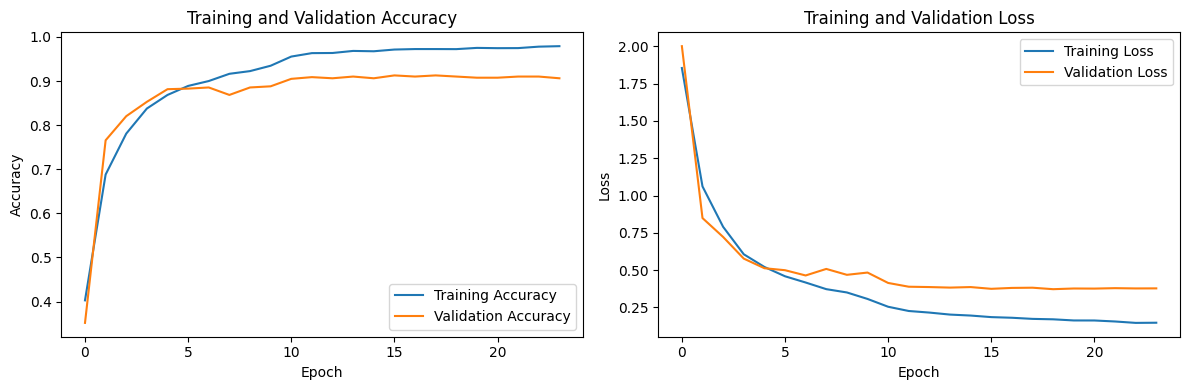

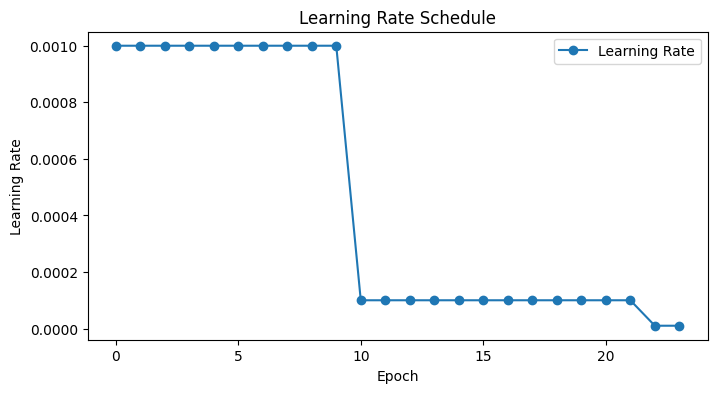

In [95]:
import matplotlib.pyplot as plt

# Access the training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
lr = history.history['lr']

# Plotting accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

# Plotting learning rate
plt.figure(figsize=(8, 4))
plt.plot(lr, label='Learning Rate', marker='o')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.show()


#### Training Approach:
The model was trained with the Adam optimizer at an initial learning rate of 0.001. A learning rate scheduler was applied, and the model was set to train for 25 epochs, with early stopping based on validation loss performance.
Training included data augmentation to improve the model's ability to generalize.

#### Training Progress:
Training began with the model learning at a reasonable pace, shown by the initial decrease in loss and increase in accuracy.
A steady convergence in training and validation accuracy was observed, with the model reaching a training accuracy peak of 97.80% and a validation accuracy peak of 91.28%.

#### Learning Rate Adjustment:
The learning rate was reduced significantly after epoch 10, from 0.001 to 0.0001, likely triggered by the learning rate scheduler in response to validation loss plateaus, allowing for finer adjustments in the model's training.

#### Performance Insights:
The final training accuracy stabilized at around 97.91%, with validation accuracy closely following at approximately 91.02%, indicating a robust generalization to unseen data.
Training loss reduced to 0.1478, and validation loss to 0.3781, demonstrating that the model predictions are well-aligned with the expected outputs.
Observations from Plots:

#### Observations:
There is a small but consistent gap between training and validation accuracy, which does not widen significantly, suggesting that the model is not overfitting. The training and validation loss trends are similar, and both metrics decrease over time without a significant divergence, which further indicates good generalization.

#### Conclusions:
The model displays a commendable learning capability with a high degree of accuracy and low loss values, reflecting a well-tuned balance between model complexity and generalization ability.